# Create a Bathymetry Surface using Landsat and ICESAT-2 data

In this notebook you will use the icesat2 data will looked at in the first notebook and the landsat composite created in the second to define a bathymetry surface of the whole region. 

This analysis is based of a key assumption which defines the scope of what is possible. That assumption is that optical reflectance (i.e., from Landsat or Sentinel-2 etc.) varies with water depth with some reflectance coming from the seabed. Clearly this only holds to a certain depth and will also be dependent on the water conditions at the time of the acquasition, for example, river mouths can be sensitivty to storms where increases in the amount of sediment in the water can reduce the ability to see through the water column. This also relevant for the icesat-2 data which has a wavelength of 532 nm. Additionally, the assumption is that reflectance will be dependent on water depth and there are other factors which could be impacting on the reflectance, for example different seabed materials or geologies might cause the reflectance to be different. 

Given these assumptions we can therefore only apply this analysis to regions of relative shallow water, up to the maximum depth of the icesat-2 measurements and where the water is clear. 



# 1. Imports

In [1]:
import os

import rsgislib

import rsgislib.regression.regresssklearn
import rsgislib.vectorutils
import rsgislib.vectorutils.createrasters
import rsgislib.zonalstats


# Import Geopandas module
import geopandas

# Import Random Forests RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import joblib

import numpy

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Import the RSGISLib plotting module which has functions for helping
# to read and visualise image data within a plot for visualisation
# within a notebook.
import rsgislib.tools.plotting

# Use this import is you have rsgislib v5.0.0 to v5.0.4.
# the following import is a local version of the imagecomp file.
from plotting import cumulative_stretch_np_arr

# Use this rsgislib import is you have rsgislib v5.0.5 or higher.
#from rsgislib.tools.plotting import cumulative_stretch_np_arr

# 2. Define Input Datasets

In [2]:
# The original ICESat-2 data.
is2_vec_file = "../data/is2_bathy/is2_bermuda_depth.gpkg"

# The Landsat Composite created in the second notebook
landsat_comp_img = "ls_comp_outs/bermuda_max_ndvi_ndwi_landsat_comp.kea"

# The land area vector layer for defining the valid area
land_area_vec_file = "../data/is2_bathy/bermuda_land_area.geojson"
land_area_vec_lyr = "bermuda_land_area"

# The ocean water area vector layer
ocean_area_vec_file = "../data/is2_bathy/bermuda_valid_water_mask.geojson"
ocean_area_vec_lyr = "bermuda_valid_water_mask"

out_dir = "ls_comps_bathy_outs"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# 3. Merge ICESAT-2 Paths

The ICESat-2 data has been provided to you as a multi-layer vector file. For this analysis we want just a single vector layer so we do not have to repeat processing steps for the different layers. The following command merges the vector layers into a single layer.


In [3]:
is2_all_vec_file = os.path.join(out_dir, "is2_bermuda_depth_sgl_lyr_all.gpkg")
is2_all_vec_lyr = "is2_bermuda_depth_sgl_lyr_all"
rsgislib.vectorutils.merge_vector_lyrs_to_gpkg(is2_vec_file, is2_all_vec_file, is2_all_vec_lyr, exists=False)

Processing: ic2_depth_bermuda_path2 has 3305 features.
Processing: ic2_depth_bermuda_path3 has 1840 features.
Processing: ic2_depth_bermuda_path4 has 5806 features.
Processing: ic2_depth_bermuda_path8 has 2344 features.
Processing: ic2_depth_bermuda_path5 has 4863 features.
Processing: ic2_depth_bermuda_path6 has 2301 features.
Processing: ic2_depth_bermuda_path7 has 5187 features.
Processing: ic2_depth_bermuda_path1 has 11380 features.


# 4. Extract Random Sample of ICESat-2 Returns

This step will extract a random 20 % sample of all the ICESat-2 returns and these will be used validate the final bathymetry surfaces. Given the large number of returns in the ICESat-2 data taking a sample to use as a validation dataset is a good idea as while k-fold and bootstrapping can be used to derieve statistics on the model accuracy it is ideal to have an independent dataset. 

In [4]:
is2_train_vec_file = os.path.join(out_dir, "is2_bermuda_depth_train.gpkg")
is2_train_vec_lyr = "is2_bermuda_depth_train"
is2_test_vec_file = os.path.join(out_dir, "is2_bermuda_depth_test.gpkg")
is2_test_vec_lyr = "is2_bermuda_depth_test"

rsgislib.vectorutils.create_train_test_smpls(is2_all_vec_file, is2_all_vec_lyr, is2_train_vec_file, is2_train_vec_lyr, is2_test_vec_file, is2_test_vec_lyr, out_format='GPKG', prop_test=0.2, tmp_dir='tmp', rnd_seed=42)

/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Number of Training Features: 29621
Number of Testing Features: 7405


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 5. Check the Data Projections. 

A common error which can occur when combining datasets from different sources is that they are in different projections. 

The code cells below show two ways you can check the projections. The first gets the WKT string and prints them out and then you can manually check they look the same.

In [5]:
is2_wkt = rsgislib.vectorutils.get_proj_wkt_from_vec(is2_vec_file, vec_lyr="ic2_depth_bermuda_path1")

ls_img_wkt = rsgislib.imageutils.get_wkt_proj_from_img(landsat_comp_img)

print(is2_wkt)
print(ls_img_wkt)


PROJCS["WGS 84 / UTM zone 20N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32620"]]
PROJCS["WGS 84 / UTM zone 20N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["

An alternative method is to compare the EPSG codes which is much easier to automate with a simple if statement:

In [6]:
is2_epsg = rsgislib.vectorutils.get_proj_epsg_from_vec(is2_vec_file, vec_lyr="ic2_depth_bermuda_path1")
ls_img_epsg = rsgislib.imageutils.get_epsg_proj_from_img(landsat_comp_img)

print(f"ICESAT-2 EPSG: {is2_epsg}")
print(f"Landsat EPSG: {ls_img_epsg}")

if is2_epsg == ls_img_epsg:
    print("Datasets have matching projections")
else:
    print("Projections DO NOT match - you probably need to sort something out here...")


ICESAT-2 EPSG: 32620
Landsat EPSG: 32620
Datasets have matching projections


Good news, the projections match so we can move on. If they did not match then you would need to reproject one of the datasets, in this case I would reproject the vector layer (i.e., the ICESat-2) as there is less error associated with reprojecting vector layers compared to raster layer which need to be resampled.

# 4. Perform Zonal Statistics for Landsat Reflectance 

Note, for this analysis we will just use the visual bands (i.e., Coastal, Blue, Green, Red) for the analysis as the NIR and SWIR bands are largely absorbed by water.

The valid ranges of values would normally be 0 (i.e., no reflectance) to 10,000 (i.e., 100 % reflectance) but for low values of reflectance it can be possible (as in this case) that the atmospheric correction has provide a physically impossible negative reflectance value. Pixel values outside of this range will be assigned the value -9999 and removed from the dataset.

In [7]:
# Perform Zonal Statistics for the Coastal band in the landsat imagery
rsgislib.zonalstats.ext_point_band_values_file(is2_train_vec_file, is2_train_vec_lyr, landsat_comp_img, img_band=1, min_thres=-100, max_thres=10000, out_no_data_val=-9999, out_field="ls_coastal")

# Perform Zonal Statistics for the Blue band in the landsat imagery
rsgislib.zonalstats.ext_point_band_values_file(is2_train_vec_file, is2_train_vec_lyr, landsat_comp_img, img_band=2, min_thres=-100, max_thres=10000, out_no_data_val=-9999, out_field="ls_blue")

# Perform Zonal Statistics for the Green band in the landsat imagery
rsgislib.zonalstats.ext_point_band_values_file(is2_train_vec_file, is2_train_vec_lyr, landsat_comp_img, img_band=3, min_thres=-100, max_thres=10000, out_no_data_val=-9999, out_field="ls_green")

# Perform Zonal Statistics for the Red band in the landsat imagery
rsgislib.zonalstats.ext_point_band_values_file(is2_train_vec_file, is2_train_vec_lyr, landsat_comp_img, img_band=4, min_thres=-100, max_thres=10000, out_no_data_val=-9999, out_field="ls_red")

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 43731.62it/s]


# 5. Remove Invalid Values From Datasets

In the next step we will remove points which do not have valid landsat reflectance values. 

In [8]:
is2_train_vld_vec_file = os.path.join(out_dir, "is2_bermuda_depth_train_vld.gpkg")
is2_train_vld_vec_lyr = "is2_bermuda_depth_train_vld"

# Check Coastal
rsgislib.vectorutils.drop_rows_by_attribute(vec_file=is2_train_vec_file, vec_lyr=is2_train_vec_lyr, sub_col="ls_coastal", sub_vals=[-9999], out_vec_file=is2_train_vld_vec_file,  out_vec_lyr=is2_train_vld_vec_lyr, out_format="GPKG")

# Check Blue - note the input and output files are now the same!
rsgislib.vectorutils.drop_rows_by_attribute(vec_file=is2_train_vld_vec_file, vec_lyr=is2_train_vld_vec_lyr, sub_col="ls_blue", sub_vals=[-9999], out_vec_file=is2_train_vld_vec_file,  out_vec_lyr=is2_train_vld_vec_lyr, out_format="GPKG")

# Check Green - note the input and output files are now the same!
rsgislib.vectorutils.drop_rows_by_attribute(vec_file=is2_train_vld_vec_file, vec_lyr=is2_train_vld_vec_lyr, sub_col="ls_green", sub_vals=[-9999], out_vec_file=is2_train_vld_vec_file,  out_vec_lyr=is2_train_vld_vec_lyr, out_format="GPKG")

# Check Red - note the input and output files are now the same!
rsgislib.vectorutils.drop_rows_by_attribute(vec_file=is2_train_vld_vec_file, vec_lyr=is2_train_vld_vec_lyr, sub_col="ls_red", sub_vals=[-9999], out_vec_file=is2_train_vld_vec_file,  out_vec_lyr=is2_train_vld_vec_lyr, out_format="GPKG")



-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [9]:
n_all_pts = rsgislib.vectorutils.get_vec_feat_count(vec_file=is2_train_vec_file, vec_lyr=is2_train_vec_lyr)
n_vld_pts = rsgislib.vectorutils.get_vec_feat_count(vec_file=is2_train_vld_vec_file, vec_lyr=is2_train_vld_vec_lyr)

print(f"There were {n_all_pts} points in the whole dataset and {n_vld_pts} valid points")


There were 29621 points in the whole dataset and 29019 valid points


# 6. Read and Plot Input Data

The first thing we are going to do is to read the input data and plot it to visualise the variables to see what the relationships look like...


In [10]:
# Open the GPKG file as a geopandas data frame - the gdf variable.
gdf = geopandas.read_file(is2_train_vld_vec_file, layer=is2_train_vld_vec_lyr)

# Get a list of the columns within the gdf dataframe
cols = list(gdf.columns)

print("All Columns: ", cols)

# Get the indepedent predictor column names
ind_vars = cols[6:10]

# Get the depth column name
depth_var = cols[4]

print("Depth Variable: ", depth_var)
print("Independent Variables: ", ind_vars)

All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'ls_red', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green', 'ls_red']


In [11]:
# Get the predictor variables and dependent variables
# from the dataframe as numpy arrays
x = gdf[ind_vars].values
y = gdf[depth_var].values

/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_84369/1384848559.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  mcolors.Colormap.set_under(cmap, color="white")
/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_84369/1384848559.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  mcolors.Colormap.set_over(cmap, color="white")


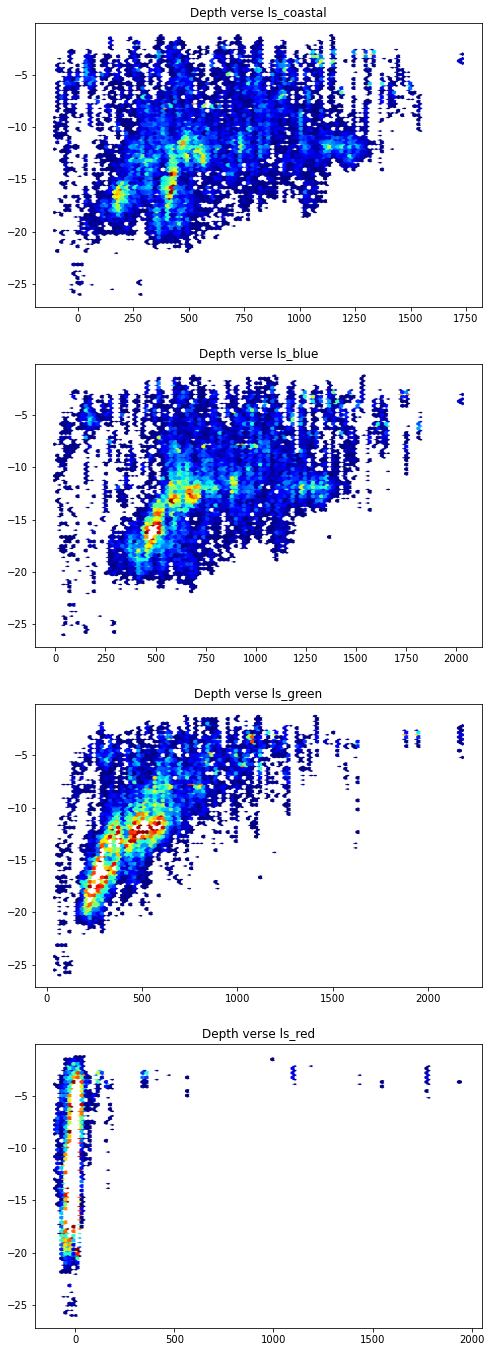

In [12]:
# Create the matplotlib figure
fig, axs = plt.subplots(4, 1, figsize=(8, 24))

cmap = plt.get_cmap("jet")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")
    
c_norm = mcolors.Normalize(vmin=1)

for i, ax in enumerate(axs):
    ax.hexbin(x[..., i], y, gridsize=100, cmap=cmap, norm=c_norm)
    ax.title.set_text("Depth verse {}".format(ind_vars[i]))


## 6.1 So what do these plots show?

In the first instance to most obvious thing is that the red reflectance doesn't seem to have have a strong correspondance with depth, with the same reflectance values being at a wide variaty of depths. We probably want to exclude that from our regression. While there is a lot of scatter the others seem to have some correspondance so we will keep those within our analysis. However, lets first look at the feature importance using the random forests model.


# 7. Fit a Random Forests Regression 

For this analysis we are going to jump a few steps to get a result so we will not test and compare different regression algorithms or look to optimise the parameters

In [13]:
skregrs_obj = RandomForestRegressor()

skregrs_obj.fit(x, y)


RandomForestRegressor()

# 8. Feature Importance

For some algorithms (e.g., Random Forests) scikit-learn allows us to get access to the feature importance information. Let's have a look at that 

In [14]:
# Get the Feature Importances from the forest
importances = skregrs_obj.feature_importances_

# However, it is better to get a set of importances through a permutation analysis:
feat_impt_rslts = permutation_importance(skregrs_obj, x, y, n_repeats=10, random_state=42, n_jobs=2)


In [15]:
for feat, impt, impt_std in zip(ind_vars, feat_impt_rslts.importances_mean, feat_impt_rslts.importances_std):
    print(f"{feat}: {impt} ({impt_std})")

ls_coastal: 0.22926935711516108 (0.001590494119888745)
ls_blue: 0.392525670376205 (0.003098493353654692)
ls_green: 1.893277505177256 (0.011596137178267688)
ls_red: 0.16092702576816717 (0.001911985146404908)


Text(0, 0.5, 'Mean decrease in impurity')

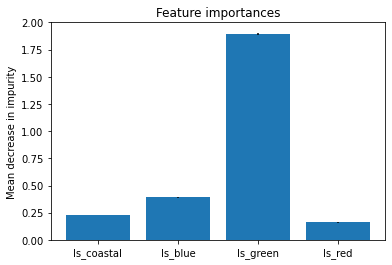

In [16]:
fig, ax = plt.subplots()
x_pos = [0,1,2,3]
plt.bar(x_pos, feat_impt_rslts.importances_mean, yerr=feat_impt_rslts.importances_std)
ax.set_xticks(x_pos, ind_vars)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

## What we can see from the information above? 

Well the first thing is that as we through the red reflecatance is contributing least to the model, we should probably remove it. We might also remove the coastal band as well. Lets try removing the red. You can try running the analysis again removing the coastal variable. You would probably want to run that through to the end of the analysis to see what the effect would be on the final result of the analysis.

# 8. Redefine the Indepedent Variables

In [17]:
ind_vars = cols[6:9]
print("Independent Variables: ", ind_vars)

x = gdf[ind_vars].values
x.shape

Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']


(29019, 3)

In [18]:
# Create a new regression object
skregrs_obj = RandomForestRegressor()
skregrs_obj.fit(x, y)

# Calculate the feature importances
feat_impt_rslts = permutation_importance(skregrs_obj, x, y, n_repeats=10, random_state=42, n_jobs=2)

# Print the importances.
for feat, impt, impt_std in zip(ind_vars, feat_impt_rslts.importances_mean, feat_impt_rslts.importances_std):
    print(f"{feat}: {impt} ({impt_std})")

ls_coastal: 0.35329529102004553 (0.0021230464053310725)
ls_blue: 0.5367770595271522 (0.0044893029557395185)
ls_green: 2.2122077535206643 (0.012957159516837995)


Text(0, 0.5, 'Mean decrease in impurity')

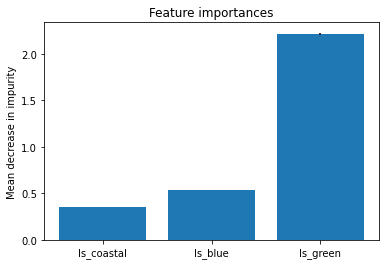

In [19]:
fig, ax = plt.subplots()
x_pos = [0,1,2]
plt.bar(x_pos, feat_impt_rslts.importances_mean, yerr=feat_impt_rslts.importances_std)
ax.set_xticks(x_pos, ind_vars)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

# 9. Fit Final Model

In [20]:
# Create a new regression object
skregrs_obj = RandomForestRegressor()
skregrs_obj.fit(x, y)

# Output model file
output_mdl_file = os.path.join(out_dir, "Bathy_RT_Depth_Model.joblib")

# Save regression model to disk:
print("Saving regression model...")
joblib.dump(skregrs_obj, output_mdl_file, ("gzip", 1))
print("Saved regression model.")

Saving regression model...
Saved regression model.


# 10. Define the Valid Area to Apply the Model to

Before applying the model we need to define the area for which the model should be applied. For this analysis that will be over the areas of water so we need to mask the land area. You have been supplied a vector layer of the land area so lets use that to create a mask.

In [21]:
land_area_img = os.path.join(out_dir, "bermuda_land_area.kea")
rsgislib.vectorutils.createrasters.rasterise_vec_lyr(land_area_vec_file, land_area_vec_lyr, landsat_comp_img, output_img=land_area_img, gdalformat='KEA', burn_val=1)

water_area_img = os.path.join(out_dir, "bermuda_water_area.kea")
rsgislib.imagecalc.image_math(land_area_img, water_area_img, "b1==1?0:1", "KEA", rsgislib.TYPE_8UINT)
rsgislib.rastergis.pop_rat_img_stats(water_area_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


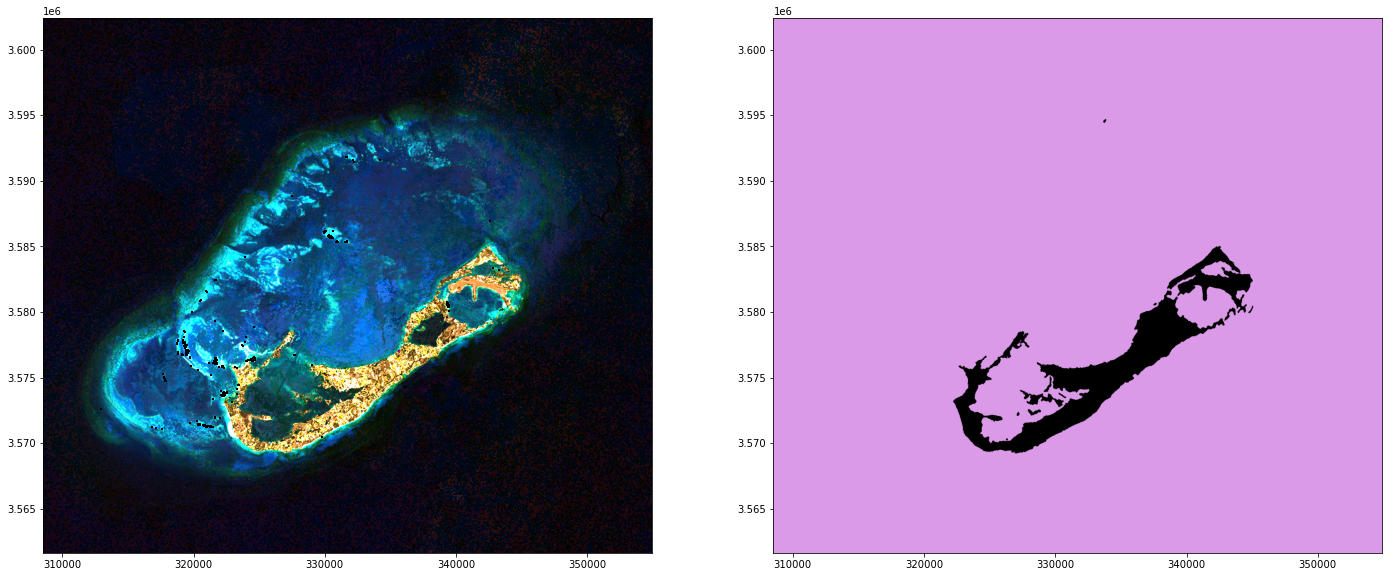

In [22]:
# Visualise with bands 4 (Red), 3 (Green) and 2 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    landsat_comp_img, bands=[4,3,2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.cumulative_stretch_np_arr(img_data, no_data_val=0.0)

# Visualise mask
(img_data_arr,
coords_bbox,
lgd_patches) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(water_area_img)


# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_data_arr, extent=coords_bbox)

# 11. Apply the Model to the Landsat Imagery

In [23]:
bathy_depths_img = os.path.join(out_dir, "bermuda_bathy_landsat_comp.kea")
rsgislib.regression.regresssklearn.apply_regress_sklearn_mdl(skregrs_obj, 1, landsat_comp_img, [1,2,3], water_area_img, 1, bathy_depths_img, gdalformat='KEA', out_band_names=["Depth"], calc_stats=True, out_no_date_val=0.0)

Applying the Regression model


  0%|          | 0/100 [00:00<?, ?it/s]

Completed


Calculating Image Pyramids.



# 12. Visualise the Result

Image Data Size: 1546 x 1358


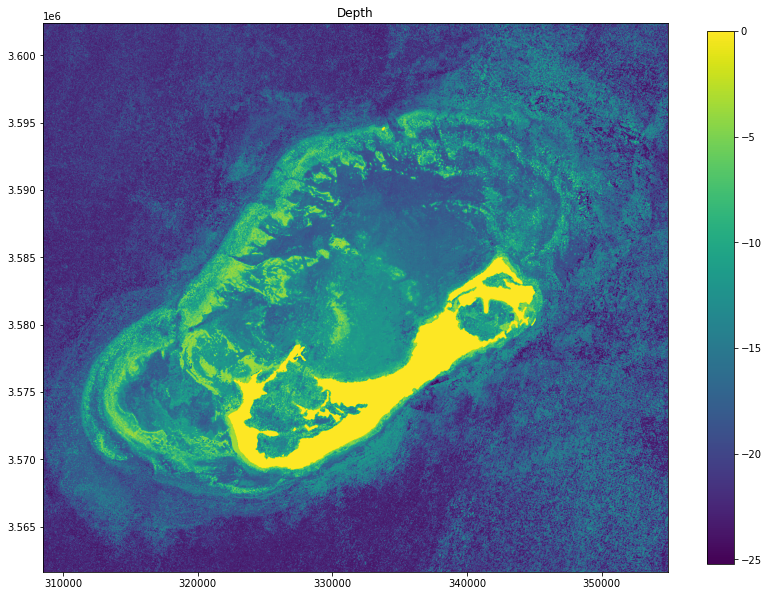

In [24]:
# Get the image data - vol_out_img
img_bathy_data, img_bathy_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depths_img, bands=[1])


fig, ax = plt.subplots(figsize=(14, 14))

dpt_plt = ax.imshow(img_bathy_data, extent=img_bathy_coords)
ax.title.set_text("Depth")
fig.colorbar(dpt_plt, ax=ax, orientation="vertical", shrink=0.7)

# 13. Assess the Quality of the Result

## 13.1 Zonal Statistics to Retrieve Depths

In [25]:
# Perform Zonal Statistics for the predicted depth
rsgislib.zonalstats.ext_point_band_values_file(is2_test_vec_file, is2_test_vec_lyr, bathy_depths_img, img_band=1, min_thres=-50, max_thres=1, out_no_data_val=9999, out_field="ls_comp_depth")

100%|█████████████████████████████████████████████████████████████████████████████████████| 7405/7405 [00:00<00:00, 32315.51it/s]


## 13.2 Read Depth Values

In [26]:
# Open the GPKG file as a geopandas data frame - the gdf variable.
gdf = geopandas.read_file(is2_test_vec_file, layer=is2_test_vec_lyr)

# Get a list of the columns within the gdf dataframe
cols = list(gdf.columns)

print("All Columns: ", cols)

vld_gpdf = gdf.drop(gdf[gdf["ls_comp_depth"] == 9999].index)

print("There were {} rows which reduced to {}".format(len(gdf), len(vld_gpdf)))

# Get the reference and predicted depth values
# from the dataframe as numpy arrays
depth_ref = vld_gpdf["Depth"].values
depth_pred = vld_gpdf["ls_comp_depth"].values

All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_comp_depth', 'geometry']
There were 7405 rows which reduced to 7330


## 13.3 Plot Reference verses Predicted

Text(0.5, 0, 'Reference Depth (m)')

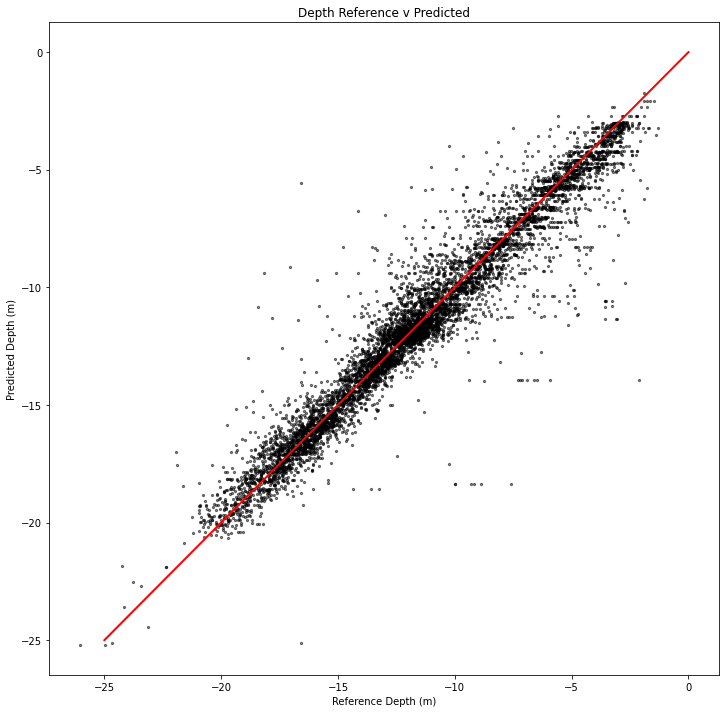

In [27]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(depth_ref, depth_pred, s=5, marker="o", color='black', alpha=0.5)
ax.plot([-25, 0], [-25, 0], color='red', linestyle='-', linewidth=2)
ax.title.set_text("Depth Reference v Predicted")
ax.set_ylabel("Predicted Depth (m)")
ax.set_xlabel("Reference Depth (m)")


## 13.4 Calculate Quality Statistics

In [28]:
reg_stats = rsgislib.regression.get_regression_stats(depth_ref, depth_pred, n_vars=1)
reg_stats

[{'r2': 0.9309548913338508,
  'explained_variance_score': 0.9309830523315854,
  'median_absolute_error': 0.4767624056926396,
  'mean_absolute_error': 0.7302124297847817,
  'mean_squared_error': 1.3691344773060135,
  'root_mean_squared_error': 1.1701001996863403,
  'norm_root_mean_squared_error': -10.170774210939191,
  'bias': -0.023630919108840753,
  'norm_bias': 0.2054052659057874,
  'bias_squared': 0.000558420337928575,
  'variance': 1.3685760569680852,
  'noise': 0}]

### What can you see from these statistics and the plot above?

*Note, your statistics will differ slightly as the split of the test/train might be different*

The first observations would be that the results looks pretty good. The results are scattered about the 1:1 line which is a good sign and this is shown as the r2 is 0.93. The RMSE is 1.18 m and the normalised RMSE is 10.2%. Therefore, we can conclusion the average error is about 1.18 metres which is about 10% of the values. 

## 13.5 Plot Residuals

In [29]:
depth_residuals = depth_ref - depth_pred

bathy_resid_plt_file = os.path.join(out_dir, "bermuda_bathy_landsat_comp_residuals.png")
rsgislib.tools.plotting.residual_plot(
    depth_ref,
    depth_residuals,
    bathy_resid_plt_file,
    title="Residuals for Bathymetry Depths",
)

![Depth Residuals](figures/bermuda_bathy_landsat_comp_residuals.png)

Again, the redisduals plot shows that isn't a particularly bias within the residuals so that looks good. There maybe a hint of something towards the ends though

## 13.6. Investigating the normality of residuals

In [30]:
depth_resid_qq_plt_file = os.path.join(out_dir, "bermuda_bathy_landsat_comp_residuals_qq.png")
rsgislib.tools.plotting.quantile_plot(
    depth_residuals,
    "Depth error (m)",
    depth_resid_qq_plt_file,
    title="Residuals for Bathymetric Depths",
)

![Depth Residuals QQ](figures/bermuda_bathy_landsat_comp_residuals_qq.png)

Looking at the QQ plot we can see that the main centre of the distribution (± 2 quantiles) is normal but there are some biases at the ends of the distribution where there is a little overestimation at the high end and underestimation at the low end. This is likely to be because there are fewer samples at the ends of the distribution.

# 14. Finalising the Bathymetric Depth Layer

The depth samples from icesat-2 were focused on the lagoon area of Bermuda which is up to about 25 m in depth. Therefore, the areas outside the lagoon should be masked from the datasets so the pixels values are all valid.


In [31]:
ocean_area_img = os.path.join(out_dir, "bermuda_ocean_area.kea")
rsgislib.vectorutils.createrasters.rasterise_vec_lyr(ocean_area_vec_file, ocean_area_vec_lyr, landsat_comp_img, output_img=ocean_area_img, gdalformat='KEA', burn_val=1)


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



In [32]:
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

bathy_depths_fnl_img = os.path.join(out_dir, "bermuda_bathy_landsat_comp_fnl.tif")
rsgislib.imageutils.mask_img(bathy_depths_img, ocean_area_img, bathy_depths_fnl_img, "GTIFF", rsgislib.TYPE_32FLOAT, 0, 1)
rsgislib.imageutils.pop_img_stats(bathy_depths_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True)

New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.




Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_84369/2232474190.py:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_under(cmap, color="white")
/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_84369/2232474190.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_over(cmap, color="white")


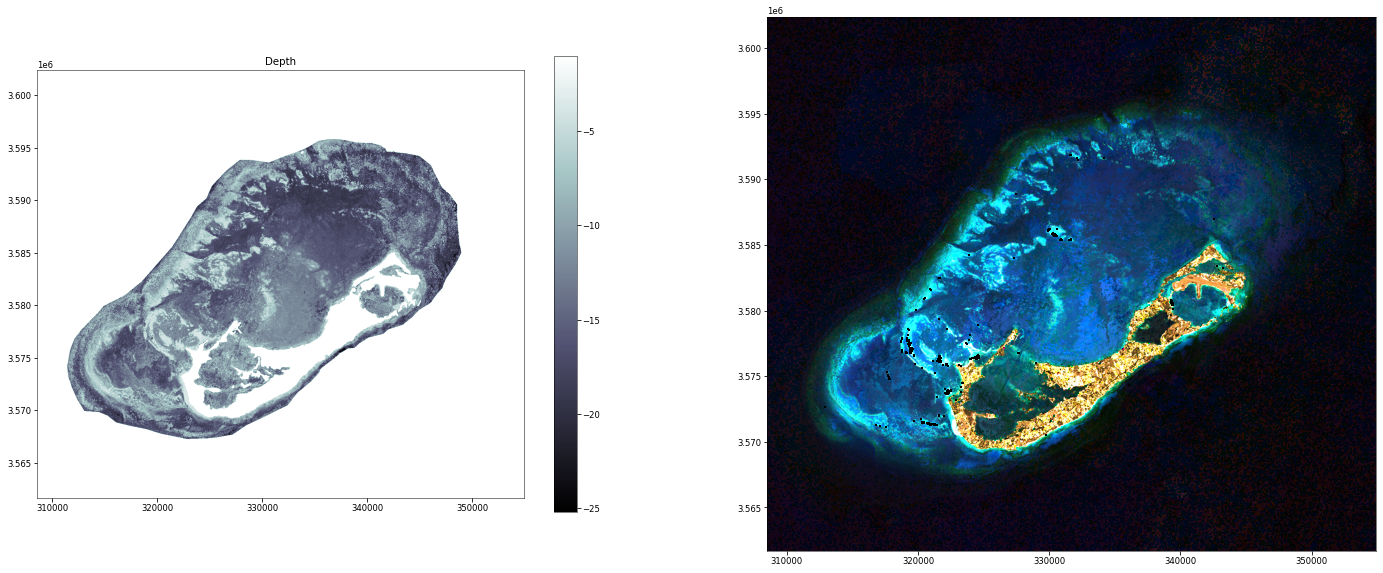

In [33]:
# Get the depth image data
img_bathy_data, img_bathy_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depths_fnl_img, bands=[1])


# Visualise with bands 4 (Red), 3 (Green) and 2 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    landsat_comp_img, bands=[4,3,2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.cumulative_stretch_np_arr(img_data, no_data_val=0.0)



cmap = plt.get_cmap("bone")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")
    
c_norm = mcolors.Normalize(vmax=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

dpt_plt = ax1.imshow(img_bathy_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm)
ax1.title.set_text("Depth")
fig.colorbar(dpt_plt, ax=ax1, orientation="vertical", shrink=0.7)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_data_strch, extent=img_coords)
